# Classify Polyps for Colon Cancer

## Load Image Dataset with OpenCV

In [18]:
import os
import csv
import cv2
import sys
import itertools
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

In [2]:
%matplotlib inline

## Pipeline Algorithm

In [19]:
def get_filepaths(basepath, file_type):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
        if filename.endswith(file_type):
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
        filenames.append(filename)
    return files, filenames

def read_img(img_path):
    image = mpimg.imread(img_path)
    print("This image is:", type(image), "with dimensions:", image.shape)
    return image

def get_images(img_files):
    images = []
    for img_file in img_files:
        image = read_img(img_file)
        images.append(image)
        return images

def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image

## Load Training, Valid & Testing Set

### Get Image Training X Filepaths

In [4]:
# Extract image along with its associated boundbox
train_X_images = []
train_y_polyp_bndbox = []

In [21]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

print(len(train_X_filepaths))
print(train_X_filepaths[0])
print(train_X_filenames[0])

28773
PolypsSet/train2019/Image/1.jpg
1.jpg


This image is: <class 'numpy.ndarray'> with dimensions: (288, 384, 3)


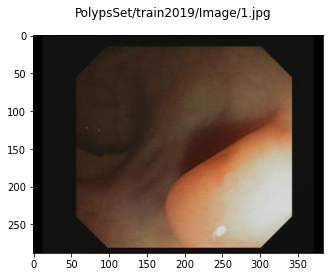

In [23]:
train_X_images = get_images(train_X_filepaths)

plt.suptitle(train_X_filepaths[0])
plt.imshow(train_X_images[0])

In [ ]:

# up_to = 5
# for filepath in itertools.islice(train_filepaths, up_to):
#     print(filepath)

### Get Image Training Y Label Bound Box Filepaths

~~~xml
<annotation>
    <folder>16</folder>
    <filename>11.jpg</filename>
    <path>/scratch/mfathan/Thesis/Dataset/Extracted/80_Videos_Frames/pretest/16/11.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>544</width>
        <height>448</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>hyperplastic</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>285</xmin>
            <ymin> 282</ymin>
            <xmax> 389</xmax>
            <ymax> 370</ymax>
        </bndbox>
    </object>
</annotation>
~~~

In [25]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)
        
print(len(train_y_filepaths))
print(train_y_filepaths[0])
print(train_y_filenames[0])

28773
PolypsSet/train2019/Annotation/1.xml
1.xml


In [11]:
train_y_tree = ET.parse(train_y_filepaths[0])
train_y_root = train_y_tree.getroot()
train_y_root.tag

'annotation'

In [13]:
train_y_object = train_y_root.find("object")
train_y_polyp_name = train_y_object.find("name").text
print("Polyp Name:", train_y_polyp_name)

Polyp Name: adenomatous


In [27]:
train_y_bndbox = train_y_object.find("bndbox")
train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
train_y_bndbox_ymax = train_y_bndbox.find("ymax").text

print("Polyp Bounding Box for:", train_X_filepaths[0])
print("xmin: ", train_y_bndbox_xmin)
print("ymin:", train_y_bndbox_ymin)
print("xmax:", train_y_bndbox_xmax)
print("ymax:", train_y_bndbox_ymax)

Polyp Bounding Box for: PolypsSet/train2019/Image/1.jpg
xmin:  164
ymin:  113
xmax:  343
ymax:  279


In [ ]:
# draw out bounding boxes like birds eye view for visual EDA


In [ ]:
# 1. Do I train the model based on image and label is the polyp name for the
# particular bounding box points is enough 
# similar to how image and steering angle were enough for Behavior Clone Driver

